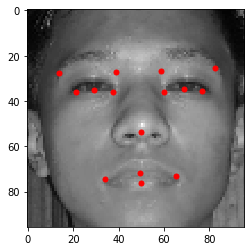

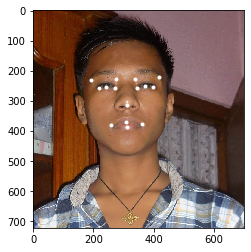

In [2]:
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time

# Load the saved model
from keras.models import load_model
model = load_model('model1.h5')  # <-- Saved model path


def detect_points(face_img):
    me  = np.array(face_img)/255
    x_test = np.expand_dims(me, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = model.predict(x_test)
    label_points = (np.squeeze(y_test)*48)+48 
    
    return label_points
    
# Load haarcascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
dimensions = (96, 96)

# Enter the path to your test image
img = cv2.imread('2.jpg')

default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
# faces = face_cascade.detectMultiScale(gray_img, 4, 6)

faces_img = np.copy(gray_img)

plt.rcParams["axes.grid"] = False


all_x_cords = []
all_y_cords = []

for i, (x,y,w,h) in enumerate(faces):
    
    h += 10
    w += 10
    x -= 5
    y -= 5
    
    just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
    cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)
    
    scale_val_x = w/96
    scale_val_y = h/96
    
    label_point = detect_points(just_face)
    all_x_cords.append((label_point[::2]*scale_val_x)+x)
    all_y_cords.append((label_point[1::2]*scale_val_y)+y)
   
   
    plt.imshow(just_face, cmap='gray')
    plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=5)
    plt.show()
    
    
plt.imshow(default_img)    
plt.plot(all_x_cords, all_y_cords, 'wo',  markersize=3)
plt.show()




In [10]:
from keras.models import load_model
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time



model = load_model('model4.h5')  # <-- Saved model path


# input video file path
input_file = 'Emo.mp4'


# output file path
output_filename = 'Testm4e.avi'  


def get_points_main(img):

    def detect_points(face_img):
        me  = np.array(face_img)/255
        x_test = np.expand_dims(me, axis=0)
        x_test = np.expand_dims(x_test, axis=3)

        y_test = model.predict(x_test)
        label_points = (np.squeeze(y_test)*48)+48


        return label_points

    # load haarcascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    dimensions = (96, 96)


    try:
        default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray_img = cv2.cvtColor(default_img, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
#         faces = face_cascade.detectMultiScale(gray_img, 4, 6)

    except:
        return []

    faces_img = np.copy(gray_img)

    plt.rcParams["axes.grid"] = False


    all_x_cords = []
    all_y_cords = []


    for i, (x,y,w,h) in enumerate(faces):

        h += 10
        w += 10
        x -= 5
        y -= 5

        try:
            just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
        except:
            return []
        cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)

        scale_val_x = w/96
        scale_val_y = h/96

        label_point = detect_points(just_face)

        all_x_cords.append((label_point[::2]*scale_val_x)+x)
        all_y_cords.append((label_point[1::2]*scale_val_y)+y)



    final_points_list = []
    try:
        for ii in range(len(all_x_cords)):
            for a_x, a_y in zip(all_x_cords[ii], all_y_cords[ii]):
                final_points_list.append([a_x, a_y])
    except:
        return final_points_list

    return final_points_list

# cap = cv2.VideoCapture(0)


cap = cv2.VideoCapture(input_file)
ret, frame = cap.read()
height, width, channel = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter(output_filename, fourcc, 10.0, (width, height))


frame_no = 0
while cap.isOpened():

    a = time.time()
    
    frame_no += 1
    ret, frame = cap.read()
    if frame_no > 75*30:
        break
    if frame_no in range(60*30, 75*30):
        points = get_points_main(frame)

        try:
            overlay = frame.copy()
        except Exception as e:
            print(e)
            break

        for point in points:

            cv2.circle(frame, tuple(point), 3, (255, 255, 255), -1)
            # cv2.line(frame, last_point, tuple(point), (0,0,255), thickness=1)
            # cv2.putText(overlay, str(i), tuple(point), 1, 1, (255, 255, 255))

        if len(points) != 0:
            o_line_points = [[12,13], [13,11], [11,14], [14,12], [12,10], [11,10], [10,3], [12,5], [11,3], [10,5], [10,4], [10,2], [5,1], [1,4], [2,0], [0,3], [5,9], [9,8], [8,4], [2,6], [6,7], [7,3]]
            num_face = len(points)//15

            for i in range(num_face):
                line_points = np.array(o_line_points) + (15*(i))

                the_color = (189, 195, 199)

                for ii in line_points:
                    cv2.line(overlay, tuple(points[ii[0]]), tuple(points[ii[1]]), the_color, thickness=1)


        opacity = 0.3
        cv2.addWeighted(overlay, opacity, frame, 1 - opacity, 0, frame)

        out.write(frame)
        # cv2.imshow('frame',frame)
        b = time.time()
        print(str((b-a)))

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
           

cap.release()
cv2.destroyAllWindows()


0.33982300758361816
0.34158873558044434
0.41674089431762695
1.1476068496704102
0.40401625633239746
0.3098130226135254
0.30780839920043945
0.30580854415893555
0.3928394317626953
0.3148040771484375
0.3217964172363281
0.3257925510406494
0.3207974433898926
0.30980634689331055
0.30780816078186035
0.3187985420227051
0.321793794631958
0.3178071975708008
0.33179330825805664
0.31680917739868164
0.3168020248413086
0.3188016414642334
0.32379722595214844
0.3207125663757324
0.34378504753112793
0.35777735710144043
0.3460726737976074
0.32380080223083496
0.3747711181640625
0.3507826328277588
0.3247966766357422
0.3427865505218506
0.35977625846862793
0.34178996086120605
0.39475417137145996
0.41774868965148926
0.385761022567749
0.3227987289428711
0.3267946243286133
0.3407864570617676
0.425736665725708
0.3228001594543457
0.30980491638183594
0.31679582595825195
0.32482290267944336
0.3068079948425293
0.3417935371398926
0.3757638931274414
0.30980658531188965
0.33878397941589355
0.33379316329956055
0.30680608

0.5596592426300049
0.828484058380127
0.8494701385498047
1.0153672695159912
0.3307955265045166
0.29781627655029297
0.3517775535583496
0.3937540054321289
0.32579684257507324
0.2988135814666748
0.31780171394348145
0.4557178020477295
0.82948899269104
1.196258544921875
0.9434125423431396
0.33979058265686035
0.343782901763916
0.32979273796081543
0.3267972469329834
0.3727753162384033
0.3557772636413574
0.32979416847229004
0.4137539863586426
0.7325515747070312
1.0003833770751953
1.0533435344696045
